# ***guilhermefa@alu.ufc.br***
# Estágio em Inteligência Artificial-Cromai

Antes de tudo, queria agradecer pela disponibilidade por parte de vocês. É um prazer estar participando desses desafios e fico feliz pela oportunidade.

Nesse documento Colab, estarei fazendo o processo de 
maneira diferente do arquivo train.py,disponibilizado por vocês.

## UTILIZAREI DOIS TIPOS DE ARQUITETURAS:
A PRIMEIRA PARTE DO NOTEBOOK EU APRESENTAREI UMA ARQUITETURA COMUM DE CNN E NA SEGUNDA PARTE UTILIZAREI DO METODO CHAMADO "ENSEMBLE MODELS"

In [1]:
!python --version

Python 3.8.10


A célula a seguir estará instalando o dataset disponiblizado por vocês e logo em seguida desempacotando o mesmo. 

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  79.0M      0  0:00:09  0:00:09 --:--:-- 69.2M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
tf.__version__

'2.11.0'

Deletando arquivos não-jpeg

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

Na célula abaixo, utilizando dos mesmos parâmetros do arquivo train.py, vou criar um dataset, utilizando o método ***image_dataset_from_directory***

In [3]:
train_path = "PetImages"

image_size = (100, 100)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds =  tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Found 23410 files belonging to 2 classes.
Using 16387 files for training.
Found 23410 files belonging to 2 classes.
Using 7023 files for validation.


# Entendendo as entrelinhas da tarefa **Classificação de Imagens**

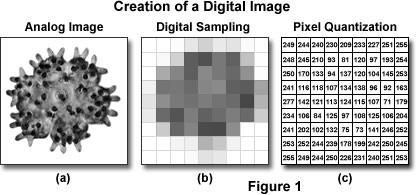

Sabendo que, as máquinas de Turing entendem imagens como uma grade de números, é plausível entender que essa "grade" pode ser uma matriz. No contexto especifíco representação de aprendizado por dados, interpreatamos vetores n-dimensionais como tensors, que é a estrutura de dados que alimenta os modelos de aprendizado.

Como a tarefa de identificar conjuntos de números nessa grade é uma tarefa linearmente separável, é possível utilizar um modelo de Machine Learning tradicional como o KNN. Contudo, por problemas de dimensionalidade com o KNN, o modelo utilizado será o CNN(convolutional neural network).

Construindo uma arquitetura CNN

In [4]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x 

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  
        previous_block_activation = x  

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

Como a tarefa em questão é uma classificação binária, a rede tem uma única unidade final e uma função de ativação Sigmóide.

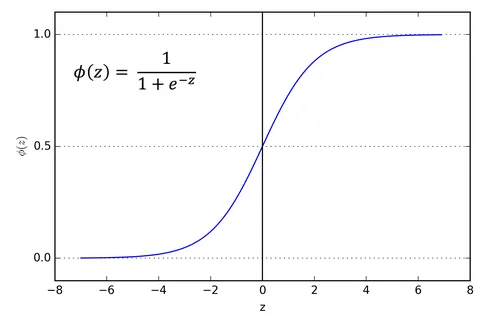

Função de ativação: A principal razão pela qual usamos a função sigmóide é porque ela existe entre (0 a 1). Portanto, é especialmente usado para modelos onde temos que prever a probabilidade como uma saída. Como a probabilidade de qualquer coisa existe apenas entre o intervalo de 0 e 1, o sigmóide é a escolha certa. No arquivo train.py, a função escolhida foi a softmax, farei comparações entre as escolhar diferentes em outro documento.

"Aprontando" o modelo/rede

In [9]:
epochs = 1

from keras import optimizers
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

Bom, apesar de ser um conjunto de dados relativamente grande para uso em estudos, é notório que, para níveis de produção, seria uma boa tomada decisão usar a técnica de Data Augmentation para aumentar esse conjunto de dados. Partindo do princípio que, ao mudar a rotação das imagens elas deixam de ser as mesmas, a técnica será aplicada.

In [6]:
import matplotlib.pyplot as plt

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Padronizando os valores do canal RGB[[0, 255]->[0, 1]]

In [10]:
from keras.callbacks import ModelCheckpoint
models_path = "models"
save_model = os.path.join(models_path, "lenet-{epoch:02d}-{accuracy:.3f}-{val_accuracy:.3f}.model")

checkpoint1 = ModelCheckpoint(save_model, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint2 = ModelCheckpoint(save_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1,checkpoint2]

H = model.fit(train_ds,
              validation_data=val_ds,
              epochs=epochs, 
              callbacks=callbacks_list)

513/513 [==============================] - ETA: 0s - loss: 0.6588 - accuracy: 0.6239
Epoch 1: val_loss improved from inf to 1.33749, saving model to models/lenet-01-0.624-0.510.model



Epoch 1: val_accuracy improved from -inf to 0.50957, saving model to models/lenet-01-0.624-0.510.model


513/513 [==============================] - 2002s 4s/step - loss: 0.6588 - accuracy: 0.6239 - val_loss: 1.3375 - val_accuracy: 0.5096


# ENSEMBLE MODELS

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix , precision_score, recall_score, f1_score ,  accuracy_score

Pre-processesamento dos dados

Por requerimento do novo modelo, utilizerei os dados no formato pandas.Dataframe

In [72]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))

df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

df['label'] = df['label'].astype('str')
df.head()

,images,label
0,PetImages/Cat/6896.jpg,0
1,PetImages/Cat/5835.jpg,0
2,PetImages/Dog/11842.jpg,1
3,PetImages/Dog/9522.jpg,1
4,PetImages/Cat/677.jpg,0


In [80]:
from sklearn.model_selection import train_test_split 
train_set, valid_set = train_test_split(df, test_size=0.15,random_state= 42)

train_set.shape, valid_set.shape

((19900, 2), (3512, 2))

In [101]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train_set,x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=64,
    class_mode='categorical'
)

val_iterator = val_generator.flow_from_dataframe(
    valid_set,x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=64,
    class_mode='categorical'
)

Found 19898 validated image filenames belonging to 2 classes.
Found 3512 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="images". These filename(s) will be ignored.
  warnings.warn(


Nova arquitetura

In [82]:
def create_model(IMG_SIZE = 128 , n = 2 ,show = True ):
    
    IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3) 
    i = Input(shape= IMG_SHAPE)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    


    x = Flatten()(x)
    x = Dropout(0.2)(x)

    # Hidden layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    # last hidden layer i.e.. output layer
    x = Dense(n, activation='sigmoid')(x)

    model = Model(i, x)

    # model description

    if(show):

        print(model.summary())
    
    return model

In [88]:
losses = {"Cross_entropy" : tf.keras.losses.BinaryCrossentropy(),
          "Huber" : tf.keras.losses.Huber()}

In [92]:
m1 = create_model()

m1.compile(loss= losses["Cross_entropy"], 
                optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
                metrics=['accuracy'])


h1 = m1.fit(train_iterator,
                    epochs=1,
                    validation_data=val_iterator,
                    steps_per_epoch = 300 )   
                  

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_63 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_64 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 32)       0   

In [106]:
m2 = create_model()
    
m2.compile(loss= losses["Huber"], 
                optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
                metrics=['accuracy'])
h2 = m2.fit(train_iterator,
                      epochs= 1,
                      validation_data=val_iterator,                    
                      steps_per_epoch = 300 
                      )  

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_48 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_84 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_49 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_85 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 64, 64, 32)       0  

## AVALIACAO DOS MODELOS POR LOSS FUNCTION

In [98]:
X_test, y_test = next(val_iterator)
labels = []

for val in y_test:
    
    labels.append(np.argmax(val))

labels = np.array(labels)
def evaluate(preds1,y_val, n = 2 ):
    
    y_preds = []
    for pred in preds1 : 
      y_preds.append(np.argmax(pred))
    
    
    
    acc = accuracy_score(y_val,y_preds)
    pre = sum(precision_score(y_val,y_preds , average= None ))/n
    recall = sum(recall_score(y_val,y_preds , average= None ))/n
    F1 = sum(f1_score(y_val,y_preds , average= None))/n
    
    
    
    print('Accuracy Score: ',acc)
    print('Precision Score : ',pre)
    print('Recall Score : ', recall)
    print('F1 Score(Class wise): ',F1)
    print('Conf Matrix Score(Class wise):\n ',confusion_matrix(y_val,y_preds ))
    
    
    res = { "acc" : acc , 
            "pre" : pre , 
            "recall" : recall , 
            "F1" : F1
    }
    
    return res

In [94]:
def plot(r):

    plt.figure(figsize=(12, 16))

    plt.subplot(4, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss Function Evolution')
    plt.legend()

    plt.subplot(4, 2, 2)
    plt.plot(r.history['accuracy'], label='accuracy')
    plt.plot(r.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy Function Evolution')
    plt.legend()

In [102]:
res1 = evaluate(m1.predict(X_test),labels)

1/1 [==============================] - 1s 545ms/step
Accuracy Score:  0.53125
Precision Score :  0.265625
Recall Score :  0.5
F1 Score(Class wise):  0.3469387755102041
Conf Matrix Score(Class wise):
  [[17  0]
 [15  0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
res2 = evaluate(m2.predict(X_test),labels)

1/1 [==============================] - 1s 1s/step
Accuracy Score:  0.53125
Precision Score :  0.265625
Recall Score :  0.5
F1 Score(Class wise):  0.3469387755102041
Conf Matrix Score(Class wise):
  [[17  0]
 [15  0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ensemble method

In [111]:
def ensemble(p1,p2):
    
    m,n = p1.shape
    
    
    z1 = np.zeros((m,n))
    
    z2 = np.zeros((m,n))
    
    z3 = np.zeros((m,n))
    
    z4 = np.zeros((m,n))
    
    z5 = np.zeros((m,n))
    
    
    
    
    for i in range(0,m):
        
        for j in range(0,n):
            
            z1[i][j] = p1[i][j] + p2[i][j]
            
            z2[i][j] = 2.1*p1[i][j] + 2.3*p2[i][j] 
            
            z3[i][j] = 2.7*p1[i][j] + 2.1*p2[i][j]
            
            z4[i][j] = max(p1[i][j] , p2[i][j])
            
            z5[i][j] = p1[i][j] * p2[i][j]
    
    
    return z1,z2,z3,z4,z5

In [112]:
p1 = m1.predict(X_test)
p2 = m2.predict(X_test)

z1,z2,z3,z4,z5 = ensemble(p1,p2)

1/1 [==============================] - 1s 878ms/step


In [116]:
en1 = evaluate(z1,labels)
en2 = evaluate(z2,labels)
en3 = evaluate(z3,labels)
en4 = evaluate(z4,labels)
en5 = evaluate(z5,labels)

Accuracy Score:  0.53125
Precision Score :  0.265625
Recall Score :  0.5
F1 Score(Class wise):  0.3469387755102041
Conf Matrix Score(Class wise):
  [[17  0]
 [15  0]]
Accuracy Score:  0.53125
Precision Score :  0.265625
Recall Score :  0.5
F1 Score(Class wise):  0.3469387755102041
Conf Matrix Score(Class wise):
  [[17  0]
 [15  0]]
Accuracy Score:  0.53125
Precision Score :  0.265625
Recall Score :  0.5
F1 Score(Class wise):  0.3469387755102041
Conf Matrix Score(Class wise):
  [[17  0]
 [15  0]]
Accuracy Score:  0.53125
Precision Score :  0.265625
Recall Score :  0.5
F1 Score(Class wise):  0.3469387755102041
Conf Matrix Score(Class wise):
  [[17  0]
 [15  0]]
Accuracy Score:  0.53125
Precision Score :  0.265625
Recall Score :  0.5
F1 Score(Class wise):  0.3469387755102041
Conf Matrix Score(Class wise):
  [[17  0]
 [15  0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr